# MLP cross validation
Classify pc vs nc RNA.
Use K=2,3,4.

Set aside the 20% test set, stratified by length.
On the remaining 80%,
perform 5-fold cross validation.

In [8]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

tf.keras.backend.set_floatx('float32')

## K-mer frequency, K=2

In [9]:
def read_features(nc_file,pc_file):
    nc = pd.read_csv (nc_file)
    pc = pd.read_csv (pc_file)
    nc['class']=0
    pc['class']=1
    rna_mer=pd.concat((nc,pc),axis=0)
    return rna_mer
rna_mer = read_features('ncRNA.2mer.features.csv','pcRNA.2mer.features.csv')
rna_mer

,seqnum,seqlen,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT,class
0,1,535,39,21,38,30,31,48,11,44,31,30,26,28,27,36,40,54,0
1,2,590,37,21,47,27,43,55,9,51,35,42,55,26,18,40,46,37,0
2,3,629,61,30,53,41,48,41,5,45,48,30,31,32,28,38,51,46,0
3,4,1319,109,68,127,77,110,75,16,82,106,79,100,58,57,61,100,93,0
4,5,323,16,21,26,12,28,23,4,21,24,23,31,19,7,9,37,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20147,20148,297,17,24,13,29,22,28,6,36,5,18,6,7,39,22,11,13,1
20148,20149,1378,118,152,47,99,142,147,31,153,36,55,25,21,119,119,34,79,1
20149,20150,1812,170,166,82,132,190,212,40,180,48,81,30,33,142,163,40,102,1
20150,20151,525,18,5,34,46,5,4,8,20,34,13,80,59,45,15,65,73,1


In [10]:
# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])
def make_train_test(data):
    bin_labels= sizebin(data)
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
    # split(x,y) expects that y is the labels. 
    # Trick: Instead of y, give it it the bin labels that we generated.
    for train_index,test_index in splitter.split(data,bin_labels):
        train_set = rna_mer.iloc[train_index]
        test_set = rna_mer.iloc[test_index]
    return (train_set,test_set)
(train_set,test_set)=make_train_test(rna_mer)
print("train,test")
train_set.shape,test_set.shape

train,test


((30290, 19), (7573, 19))

In [11]:
def prepare_test_set(test_set):
    y_test=   test_set[['class']].copy()
    X_test=   test_set.div(test_set['seqlen'],axis=0)
    X_test=   X_test.drop(columns=['class','seqnum','seqlen'])
    return (X_test,y_test)
(X_test,y_test)=prepare_test_set(test_set)

def prepare_train_set(train_set):
    y_train_all=  train_set[['class']].copy()
    X_train_all=  train_set.div(train_set['seqlen'],axis=0)
    X_train_all=  X_train_all.drop(columns=['class','seqnum','seqlen'])
    return (X_train_all,y_train_all)

(X_train_all,y_train_all)=prepare_train_set(train_set)
X_train_all.shape,y_train_all.shape

((30290, 16), (30290, 1))

In [12]:
act="sigmoid"
def builder():
    mlp = keras.models.Sequential([
        keras.layers.LayerNormalization(trainable=False),
        keras.layers.Dense(32, activation=act,dtype='float32'),
        keras.layers.Dense(32, activation=act,dtype='float32'),
        keras.layers.Dense(1,  activation=act,dtype='float32')
    ])
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

estimator= KerasRegressor( #batch_size=10
    build_fn=builder, epochs=5, verbose=1
)
kfold= RepeatedKFold(n_splits=5, n_repeats=1)
results= cross_val_score(
    estimator, X_train_all, y_train_all, cv=kfold, n_jobs=2)
results

array([-0.57922715, -0.59338558, -0.59425354, -0.58580965, -0.5878067 ])

In [9]:
# See page 302 for explanation of these parameters.
# See also the keras docs e.g. 
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy
# Note keras can take parameters for % train vs % validation.

# It seems the BinaryCrossentropy assumes labels are probabilities.
# Instead of loss="binary_crossentropy",
bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
# Tried optimizers SGD, Adam
mlp2mer.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])

# With one dense layer and Adam optimizer, accuracy increases slowly.
history2mer = mlp2mer.fit(X_train,y_train,epochs=100,validation_data=(X_valid,y_valid))

NameError: name 'X_train' is not defined

In [10]:
pd.DataFrame(history2mer.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

NameError: name 'history2mer' is not defined

## K-mer frequency, K=3

In [8]:
rna_mer = read_features('ncRNA.3mer.features.csv','pcRNA.3mer.features.csv')
(train_set,test_set)=make_train_test(rna_mer)
(X_train,y_train,X_valid,y_valid)=prepare_train_set(train_set)

In [9]:
act="sigmoid"
mlp3mer = keras.models.Sequential([
    keras.layers.LayerNormalization(trainable=False),
    keras.layers.Dense(32, activation=act,dtype='float32'),
    keras.layers.Dense(32, activation=act,dtype='float32'),
    keras.layers.Dense(1,  activation=act,dtype='float32')
])
bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
mlp3mer.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
history3mer = mlp3mer.fit(X_train,y_train,epochs=100,validation_data=(X_valid,y_valid))

Epoch 1/100
758/758 [==============================] - 2s 2ms/step - loss: 0.5930 - accuracy: 0.6764 - val_loss: 0.5191 - val_accuracy: 0.7511
Epoch 2/100
758/758 [==============================] - 2s 2ms/step - loss: 0.5048 - accuracy: 0.7590 - val_loss: 0.4997 - val_accuracy: 0.7542
Epoch 3/100
758/758 [==============================] - 2s 2ms/step - loss: 0.4940 - accuracy: 0.7666 - val_loss: 0.4954 - val_accuracy: 0.7565
Epoch 4/100
758/758 [==============================] - 2s 2ms/step - loss: 0.4904 - accuracy: 0.7675 - val_loss: 0.4929 - val_accuracy: 0.7549
Epoch 5/100
758/758 [==============================] - 2s 2ms/step - loss: 0.4870 - accuracy: 0.7709 - val_loss: 0.4908 - val_accuracy: 0.7552
Epoch 6/100
758/758 [==============================] - 2s 2ms/step - loss: 0.4823 - accuracy: 0.7718 - val_loss: 0.4882 - val_accuracy: 0.7567
Epoch 7/100
758/758 [==============================] - 2s 2ms/step - loss: 0.4769 - accuracy: 0.7739 - val_loss: 0.4815 - val_accuracy: 0.7605

Epoch 58/100
758/758 [==============================] - 2s 2ms/step - loss: 0.3783 - accuracy: 0.8355 - val_loss: 0.3988 - val_accuracy: 0.8260
Epoch 59/100
758/758 [==============================] - 2s 2ms/step - loss: 0.3764 - accuracy: 0.8367 - val_loss: 0.4008 - val_accuracy: 0.8234
Epoch 60/100
758/758 [==============================] - 2s 2ms/step - loss: 0.3760 - accuracy: 0.8360 - val_loss: 0.4016 - val_accuracy: 0.8247
Epoch 61/100
758/758 [==============================] - 2s 2ms/step - loss: 0.3755 - accuracy: 0.8362 - val_loss: 0.4008 - val_accuracy: 0.8252
Epoch 62/100
758/758 [==============================] - 2s 2ms/step - loss: 0.3749 - accuracy: 0.8358 - val_loss: 0.3980 - val_accuracy: 0.8262
Epoch 63/100
758/758 [==============================] - 2s 3ms/step - loss: 0.3744 - accuracy: 0.8364 - val_loss: 0.4060 - val_accuracy: 0.8230
Epoch 64/100
758/758 [==============================] - 2s 2ms/step - loss: 0.3725 - accuracy: 0.8390 - val_loss: 0.4016 - val_accuracy:

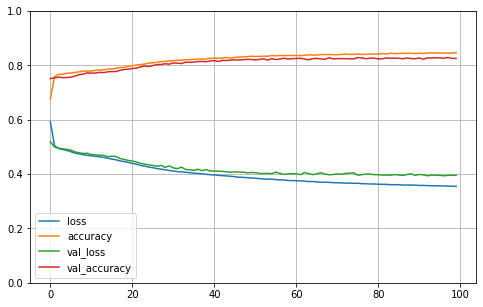

In [10]:
pd.DataFrame(history3mer.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## K-mer frequency, K=4

In [12]:
rna_mer = read_features('ncRNA.4mer.features.csv','pcRNA.4mer.features.csv')
(train_set,test_set)=make_train_test(rna_mer)
(X_train,y_train,X_valid,y_valid)=prepare_train_set(train_set)
act="sigmoid"
mlp4mer = keras.models.Sequential([
    keras.layers.LayerNormalization(trainable=False),
    keras.layers.Dense(32, activation=act,dtype='float32'),
    keras.layers.Dense(32, activation=act,dtype='float32'),
    keras.layers.Dense(1,  activation=act,dtype='float32')
])
bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
mlp4mer.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
history4mer = mlp4mer.fit(X_train,y_train,epochs=100,validation_data=(X_valid,y_valid))

Epoch 1/100
758/758 [==============================] - 2s 3ms/step - loss: 0.5527 - accuracy: 0.7167 - val_loss: 0.4602 - val_accuracy: 0.7862
Epoch 2/100
758/758 [==============================] - 2s 3ms/step - loss: 0.4407 - accuracy: 0.7984 - val_loss: 0.4426 - val_accuracy: 0.7912
Epoch 3/100
758/758 [==============================] - 2s 3ms/step - loss: 0.4295 - accuracy: 0.8019 - val_loss: 0.4440 - val_accuracy: 0.7905
Epoch 4/100
758/758 [==============================] - 2s 3ms/step - loss: 0.4261 - accuracy: 0.8046 - val_loss: 0.4381 - val_accuracy: 0.7983
Epoch 5/100
758/758 [==============================] - 2s 3ms/step - loss: 0.4246 - accuracy: 0.8063 - val_loss: 0.4361 - val_accuracy: 0.7991
Epoch 6/100
758/758 [==============================] - 2s 3ms/step - loss: 0.4236 - accuracy: 0.8065 - val_loss: 0.4370 - val_accuracy: 0.7981
Epoch 7/100
758/758 [==============================] - 2s 3ms/step - loss: 0.4232 - accuracy: 0.8080 - val_loss: 0.4353 - val_accuracy: 0.7986

Epoch 58/100
758/758 [==============================] - 2s 2ms/step - loss: 0.3075 - accuracy: 0.8722 - val_loss: 0.3567 - val_accuracy: 0.8523
Epoch 59/100
758/758 [==============================] - 2s 2ms/step - loss: 0.3061 - accuracy: 0.8722 - val_loss: 0.3534 - val_accuracy: 0.8524
Epoch 60/100
758/758 [==============================] - 2s 2ms/step - loss: 0.3045 - accuracy: 0.8737 - val_loss: 0.3506 - val_accuracy: 0.8536
Epoch 61/100
758/758 [==============================] - 2s 3ms/step - loss: 0.3021 - accuracy: 0.8758 - val_loss: 0.3603 - val_accuracy: 0.8462
Epoch 62/100
758/758 [==============================] - 2s 2ms/step - loss: 0.3007 - accuracy: 0.8747 - val_loss: 0.3561 - val_accuracy: 0.8495
Epoch 63/100
758/758 [==============================] - 2s 2ms/step - loss: 0.2992 - accuracy: 0.8764 - val_loss: 0.3530 - val_accuracy: 0.8526
Epoch 64/100
758/758 [==============================] - 2s 3ms/step - loss: 0.2976 - accuracy: 0.8766 - val_loss: 0.3511 - val_accuracy:

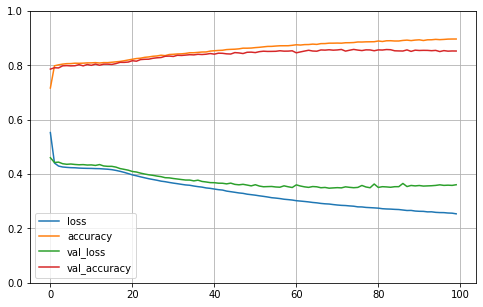

In [13]:
pd.DataFrame(history4mer.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()